In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
hbar=6.582119569*1e-16#eV*s
Energy_unit=1.2414*1e-4#eV
H_unit=1e-12*Energy_unit/hbar
H_unit

0.18860186099423928

In [2]:
I=np.eye(9, dtype="complex64")

start_vert=1 #starting site
sink_connect=3 #site connected to the sink

#Non-diagonal part of the Hamiltonian
hbar=6.582119569*1e-16#eV*s
Energy_unit=1.2414*1e-4#eV
H_unit=1e-12*Energy_unit/hbar

H_I=H_unit*np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, -104.1, 5.1, -4.3, 4.7, -15.1, -7.8, 0],
    [0, -104.1, 0, 32.6, 7.1, 5.4, 8.3, 0.8, 0],
    [0, 5.1, 32.6, 0.0, -46.8, 1.0, -8.1, 5.1, 0],
    [0, -4.3, 7.1, -46.8, 0, -70.7, -14.7, -61.5, 0],
    [0, 4.7, 5.4, 1.0, -70.7, 0, 89.7, -2.5, 0],
    [0, -15.1, 8.3, -8.1, -14.7, 89.7, 0, 32.7, 0],
    [0, -7.8, 0.8, 5.1, -61.5, -2.5, 32.7, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype="complex64")

L_uni_I = np.kron(I, H_I)-np.kron(H_I.transpose().conjugate(), I) #Corresponding term for the vectorized Lindblad equation
Tensor_L_uni_I = tf.convert_to_tensor(L_uni_I) #Convert L_uni_I to a tensor object


#Define sigma+_ij and sigma-_ij matrices to write down the dissipators
Sm=[]
Sp=[]
for k in range(8):
    smk=np.zeros([9,9], dtype="complex64")
    smk[0,k]=1
    spk=np.zeros([9,9], dtype="complex64")
    spk[k,0]=1
    
    Sm+=[smk]
    Sp+=[spk]
sm=np.zeros([9,9], dtype="complex64") #sigma+_3s and sigma-_3s
sm[8,sink_connect]=1
sp=np.zeros([9,9], dtype="complex64")
sp[sink_connect,8]=1


#Sink state
sink=np.zeros([9,9], dtype="complex64")
sink[8,8]=1
sink=sink.reshape(9*9)
Tensor_sink=tf.convert_to_tensor(sink)

#Matrices |i><i| in the vectorized ME notation (required for the optimization of the diagonal terms of the Hamiltonian)
basis_Hd=[]
for k in range(1,8):
    basis_k=np.zeros([9,9], dtype="complex64")
    basis_k[k,k]=1
    basis_k=np.kron(I, basis_k)-np.kron(basis_k.transpose().conjugate(), I)
    basis_Hd+=[basis_k]
basis_Hd=tf.convert_to_tensor(basis_Hd, dtype="complex64")

In [3]:
#Optimization
def RMSprop(X0, iterations, learning_rate, beta=0.9, eps=1e-8):
    global T, Tensor_rho0, Tensor_L_sink, Tensor_L_diss, Tensor_L_deph, alpha
    
    x=tf.Variable(tf.constant(np.complex64(X0)), shape=[7]) #Variables to optimize <- (diag elements of H)/alpha
    
    cost=np.zeros(iterations) #taking track of the progresses
    v=tf.constant(np.zeros(7, dtype="complex64")) #For updates of RMSprop
    
    for n in range(iterations):
        
        #Gradient tape for Automatic Differentiation with Tensorflow
        with tf.GradientTape() as tape:
            z1 = tf.reduce_sum(x[:, tf.newaxis, tf.newaxis] * basis_Hd, axis=0) #use x to build the vectorized term of the diagonal part of H
            z2 = tf.linalg.expm((-1j*(alpha*z1+Tensor_L_uni_I)+Tensor_L_diss+Tensor_L_deph+Tensor_L_sink)*T) #Liouvillian
            z3 = tf.linalg.matvec(z2, Tensor_rho0) #State evolution
            y = 1-tf.tensordot(Tensor_sink, z3, axes=1) #1-SinkPopulation (quantity to minimize)
            
        dy_dx = tape.gradient(y, x) #Caclulate Gradient with AD
        
        #Updates
        v = beta * v + (1.0 - beta) * dy_dx**2
        x = tf.cast(tf.math.real(x - learning_rate*dy_dx/(tf.math.sqrt(v+eps))), dtype="complex64")
        x= tf.Variable(x)
        
        cost[n] = y.numpy().real
        
    return x.numpy().real, cost

[ 12.389539   -2.1010413 -10.577568   -6.8308034  -5.7672405  10.511105
   0.7862378]
0.9552162289619446
0.9708135724067688


Text(0, 0.5, 'Sink population')

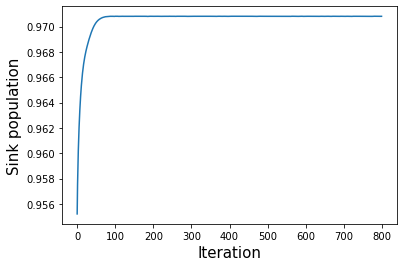

In [4]:
#Define dissipators
Gamma_to_sink=6.283
Gamma=np.array(7*[5.*1e-4])
gamma=np.array([0.157, 9.432, 7.797, 9.432, 7.797, 0.922, 9.433])
L_sink=Gamma_to_sink*(2*np.kron(sp.transpose(), sm)-np.kron(I, sp@sm)-np.kron((sp@sm).transpose().conjugate(), I))
L_diss=sum([Gamma[k-1]*(2*np.kron(Sp[k].transpose(), Sm[k])-np.kron(I, Sp[k]@Sm[k])-np.kron((Sp[k]@Sm[k]).transpose().conjugate(), I)) for k in range(1,8)])
L_deph=sum([gamma[k-1]*(2*np.kron((Sp[k]@Sm[k]).transpose(),Sp[k]@Sm[k])-np.kron(I, Sp[k]@Sm[k])-np.kron((Sp[k]@Sm[k]).transpose().conjugate(), I)) for k in range(1,8)])
Tensor_L_diss=tf.convert_to_tensor(L_diss)
Tensor_L_deph=tf.convert_to_tensor(L_deph)
Tensor_L_sink=tf.convert_to_tensor(L_sink)

#Initial state
rho0=np.zeros([9,9], dtype="complex64")
rho0[start_vert,start_vert]=1
rho0=rho0.reshape(9*9)
Tensor_rho0=tf.convert_to_tensor(rho0)

#Total time
T=5.

#Optimization
alpha=200
X0=np.zeros(7, dtype="complex64")
psink_opt, C = RMSprop(X0, 800, 0.001)

h_opt_gammaref=alpha*psink_opt

#Show results
print(h_opt_gammaref) #Optimal diagonal elements of the Hamiltonian
print(1-C[0]) #not optimized sink population
print(1-C[-1]) #Optimal sink population
plt.plot(1-C)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Sink population", fontsize=15)

Text(0, 0.5, 'Sink population')

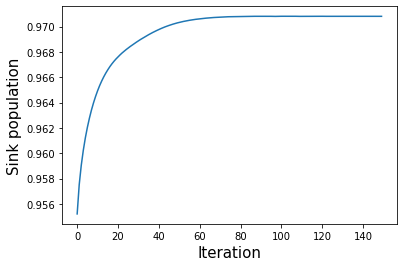

In [6]:
plt.plot(1-C[:150])
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Sink population", fontsize=15)

[ 8.207897   2.583293  -8.635124  -0.8103952 -3.669069   2.7241602
 -1.6151831]
0.9227350950241089
0.9808787703514099


Text(0, 0.5, 'Sink population')

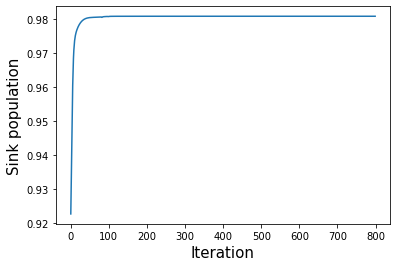

In [12]:
#Define dissipators
Gamma_to_sink=6.283
Gamma=np.array(7*[5.*1e-4])
gamma=np.array(7*[1.])
L_sink=Gamma_to_sink*(2*np.kron(sp.transpose(), sm)-np.kron(I, sp@sm)-np.kron((sp@sm).transpose().conjugate(), I))
L_diss=sum([Gamma[k-1]*(2*np.kron(Sp[k].transpose(), Sm[k])-np.kron(I, Sp[k]@Sm[k])-np.kron((Sp[k]@Sm[k]).transpose().conjugate(), I)) for k in range(1,8)])
L_deph=sum([gamma[k-1]*(2*np.kron((Sp[k]@Sm[k]).transpose(),Sp[k]@Sm[k])-np.kron(I, Sp[k]@Sm[k])-np.kron((Sp[k]@Sm[k]).transpose().conjugate(), I)) for k in range(1,8)])
Tensor_L_diss=tf.convert_to_tensor(L_diss)
Tensor_L_deph=tf.convert_to_tensor(L_deph)
Tensor_L_sink=tf.convert_to_tensor(L_sink)

#Initial state
rho0=np.zeros([9,9], dtype="complex64")
rho0[start_vert,start_vert]=1
rho0=rho0.reshape(9*9)
Tensor_rho0=tf.convert_to_tensor(rho0)

#Total time
T=5.

#Optimization
alpha=200
X0=np.zeros(7, dtype="complex64")
psink_opt, C = RMSprop(X0, 800, 0.001)

h_opt_gamma1=alpha*psink_opt

#Show results
print(h_opt_gamma1) #Optimal diagonal elements of the Hamiltonian
print(1-C[0]) #not optimized sink population
print(1-C[-1]) #Optimal sink population
plt.plot(1-C)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Sink population", fontsize=15)

[  -2.49071      -0.32638294    3.0335948    -8.163719     80.00663
 -107.273735      7.457055  ]
0.6393032073974609
0.9890434145927429


Text(0, 0.5, 'Sink population')

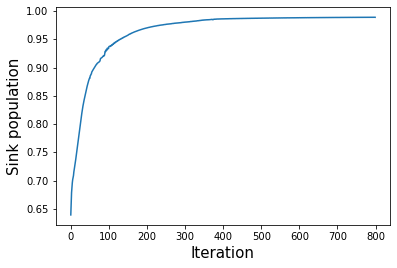

In [13]:
#Define dissipators
Gamma_to_sink=6.283
Gamma=np.array(7*[5.*1e-4])
gamma=np.zeros(7)
L_sink=Gamma_to_sink*(2*np.kron(sp.transpose(), sm)-np.kron(I, sp@sm)-np.kron((sp@sm).transpose().conjugate(), I))
L_diss=sum([Gamma[k-1]*(2*np.kron(Sp[k].transpose(), Sm[k])-np.kron(I, Sp[k]@Sm[k])-np.kron((Sp[k]@Sm[k]).transpose().conjugate(), I)) for k in range(1,8)])
L_deph=sum([gamma[k-1]*(2*np.kron((Sp[k]@Sm[k]).transpose(),Sp[k]@Sm[k])-np.kron(I, Sp[k]@Sm[k])-np.kron((Sp[k]@Sm[k]).transpose().conjugate(), I)) for k in range(1,8)])
Tensor_L_diss=tf.convert_to_tensor(L_diss)
Tensor_L_deph=tf.convert_to_tensor(L_deph)
Tensor_L_sink=tf.convert_to_tensor(L_sink)

#Initial state
rho0=np.zeros([9,9], dtype="complex64")
rho0[start_vert,start_vert]=1
rho0=rho0.reshape(9*9)
Tensor_rho0=tf.convert_to_tensor(rho0)

#Total time
T=5.

#Optimization
alpha=200
X0=np.zeros(7, dtype="complex64")
psink_opt, C = RMSprop(X0, 800, 0.001)

h_opt_gamma0=alpha*psink_opt

#Show results
print(h_opt_gamma0) #Optimal diagonal elements of the Hamiltonian
print(1-C[0]) #not optimized sink population
print(1-C[-1]) #Optimal sink population
plt.plot(1-C)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Sink population", fontsize=15)

In [14]:
#Define dissipators
Gamma_to_sink=6.283
Gamma=np.array(7*[5.*1e-4])
L_sink=Gamma_to_sink*(2*np.kron(sp.transpose(), sm)-np.kron(I, sp@sm)-np.kron((sp@sm).transpose().conjugate(), I))
L_diss=sum([Gamma[k-1]*(2*np.kron(Sp[k].transpose(), Sm[k])-np.kron(I, Sp[k]@Sm[k])-np.kron((Sp[k]@Sm[k]).transpose().conjugate(), I)) for k in range(1,8)])
Tensor_L_diss=tf.convert_to_tensor(L_diss)
Tensor_L_sink=tf.convert_to_tensor(L_sink)

#Initial state
rho0=np.zeros([9,9], dtype="complex64")
rho0[start_vert,start_vert]=1
rho0=rho0.reshape(9*9)
Tensor_rho0=tf.convert_to_tensor(rho0)

#Total time
T=5.

alpha=200
gammaList=np.linspace(0., 20., 41)
OptSink=[]
nonOptSink=[]
Errs=[]

for gk in range(gammaList.shape[0]):
    gamma=np.array(7*[gammaList[gk]])
    L_deph=sum([gamma[k-1]*(2*np.kron((Sp[k]@Sm[k]).transpose(),Sp[k]@Sm[k])-np.kron(I, Sp[k]@Sm[k])-np.kron((Sp[k]@Sm[k]).transpose().conjugate(), I)) for k in range(1,8)])
    Tensor_L_deph=tf.convert_to_tensor(L_deph)
    
    X0=np.zeros(7, dtype="complex64")
    psink_opt, C = RMSprop(X0, 800, 0.001)
    
    OptSink+=[1-C[-1]]
    nonOptSink+=[1-C[0]]
    Errs+=[abs(C[-1]-C[-2])]
    
    print(gamma[0], nonOptSink[gk], OptSink[gk], Errs[gk])

0.0 0.6393032073974609 0.9890434145927429 0.0001004338264465332
0.5 0.8549590706825256 0.9853280186653137 1.4007091522216797e-05
1.0 0.9227350950241089 0.9808787703514099 1.1920928955078125e-07
1.5 0.9489008188247681 0.9864444136619568 1.8477439880371094e-06
2.0 0.9603055119514465 0.9875312447547913 5.960464477539063e-08
2.5 0.9656527638435364 0.9872393608093262 1.7881393432617188e-07
3.0 0.9681782126426697 0.9864031672477722 2.562999725341797e-06
3.5 0.9692589044570923 0.9853174090385437 1.1920928955078125e-07
4.0 0.9695287942886353 0.9840919375419617 1.7881393432617188e-07
4.5 0.9693155884742737 0.9827825427055359 1.2516975402832031e-06
5.0 0.9687960743904114 0.9814169406890869 3.5762786865234375e-07
5.5 0.9680635333061218 0.979511559009552 1.8477439880371094e-06
6.0 0.9671826362609863 0.97819584608078 1.7285346984863281e-06
6.5 0.9661828875541687 0.9768182635307312 3.5762786865234375e-07
7.0 0.965087890625 0.9754037857055664 1.0132789611816406e-06
7.5 0.9639064073562622 0.9739542007

Text(0, 0.5, '$r_{s}^T$')

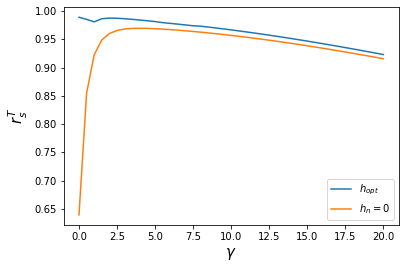

In [15]:
plt.plot(gammaList, OptSink, label="$h_{opt}$")
plt.plot(gammaList, nonOptSink, label="$h_{n}=0$")
plt.legend()

plt.xlabel("$\gamma$", fontsize=15)
plt.ylabel("$r_{s}^T$", fontsize=15)